In [43]:
import collections
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import pickle

#### Getting the data

In [45]:
algorithm = 'louvain' # 'louvain' or 'infomap'

In [3]:
# output_path = f"../../../results/SNAM/communities"

# before_comms = pickle.load(open(os.path.join(output_path, 'before_comms.pickle'), 'rb'))
# during_comms = pickle.load(open(os.path.join(output_path, 'during_comms.pickle'), 'rb'))
# after_comms = pickle.load(open(os.path.join(output_path, 'after_comms.pickle'), 'rb'))

# output_path = f"../../../results/SNAM/communities/comms_composition"

# before_community_composition = pickle.load(open(os.path.join(output_path, 'before_community_composition.pickle'), 'rb'))
# during_community_composition = pickle.load(open(os.path.join(output_path, 'during_community_composition.pickle'), 'rb'))
# after_community_composition = pickle.load(open(os.path.join(output_path, 'after_community_composition.pickle'), 'rb'))

In [60]:
output_path = f"../../../results/SNAM/communities"

# [(comm_id, comm, comm_political_composition), ..., (comm_id, comm, comm_political_composition)]
before_comms_data = pickle.load(open(os.path.join(output_path, 'before_communities_all_data_list.pickle'), 'rb'))
during_comms_data = pickle.load(open(os.path.join(output_path, 'during_communities_all_data_list.pickle'), 'rb'))
after_comms_data = pickle.load(open(os.path.join(output_path, 'after_communities_all_data_list.pickle'), 'rb'))

In [50]:
# load party info
output_path = f"../../../results/SNAM/communities/comms_composition"

before_parties = pickle.load(open(os.path.join(output_path, 'before_parties.pickle'), 'rb'))
during_parties = pickle.load(open(os.path.join(output_path, 'during_parties.pickle'), 'rb'))
after_parties = pickle.load(open(os.path.join(output_path, 'after_parties.pickle'), 'rb'))

In [51]:
party_acronyms = {
    'Alleanza Verdi Sinistra': 'AVS',
    'Azione - Italia Viva': 'Az-Iv',
    'Forza Italia': 'FI',
    "Fratelli d'Italia": 'FdI',
    'Lega': 'L',
    'Movimento 5s': 'M5s',
    'Noi moderati': 'NM',
    'Partito Democratico': 'PD'
}

In [8]:
# # retrieve the 10 bigger communities
# top_n = 5

# before_temp = [(comm, len(comm)) for comm in before_comms]
# before_top_comms = [data[0] for data in sorted(before_temp, key=lambda x: x[1], reverse=True)][:11]

# during_temp = [(comm, len(comm)) for comm in during_comms]
# during_top_comms = [data[0] for data in sorted(during_temp, key=lambda x: x[1], reverse=True)][:14]

# after_temp = [(comm, len(comm)) for comm in after_comms]
# after_top_comms = [data[0] for data in sorted(after_temp, key=lambda x: x[1], reverse=True)][:16]

In [63]:
# sort before_comms_data by the size of the communities
sorted_before_comms_data = sorted(before_comms_data, key=lambda x: len(x[1]), reverse=True)
sorted_during_comms_data = sorted(during_comms_data, key=lambda x: len(x[1]), reverse=True)
sorted_after_comms_data = sorted(after_comms_data, key=lambda x: len(x[1]), reverse=True)

In [32]:
# before_top_comms_idxs = [data[1] for data in sorted(zip(before_temp, range(0, len(before_temp))), key=lambda x: x[0][1], reverse=True)][:11]
# during_top_comms_idxs = [data[1] for data in sorted(zip(during_temp, range(0, len(during_temp))), key=lambda x: x[0][1], reverse=True)][:14]
# after_top_comms_idxs = [data[1] for data in sorted(zip(after_temp, range(0, len(after_temp))), key=lambda x: x[0][1], reverse=True)][:16]

In [33]:
# before_top_comms_idxs, during_top_comms_idxs, after_top_comms_idxs

([7, 12, 2, 11, 3, 0, 17, 13, 8, 25, 10],
 [9, 19, 2, 8, 4, 75, 3, 129, 103, 21, 229, 38, 6, 14],
 [18, 236, 13, 4, 2, 1, 9, 19, 34, 157, 38, 78, 8, 6, 22, 53])

In [34]:
# before_top_comms_size = [data[0][1] for data in sorted(zip(before_temp, range(0, len(before_temp))), key=lambda x: x[0][1], reverse=True)][:11]
# during_top_comms_size = [data[0][1] for data in sorted(zip(during_temp, range(0, len(during_temp))), key=lambda x: x[0][1], reverse=True)][:14]
# after_top_comms_size = [data[0][1] for data in sorted(zip(after_temp, range(0, len(after_temp))), key=lambda x: x[0][1], reverse=True)][:16]

In [35]:
# before_top_comms_size, during_top_comms_size, after_top_comms_size

([2827, 2549, 2057, 1845, 1832, 406, 92, 89, 85, 33, 29],
 [3942, 3205, 2874, 2700, 2568, 486, 478, 227, 216, 165, 46, 40, 23, 22],
 [3870, 2435, 2244, 2065, 1940, 1418, 421, 94, 74, 74, 67, 49, 36, 33, 27, 27])

#### Migration analysis

##### Before -> During

In [10]:
before_during_migration = np.zeros([len(sorted_before_comms_data), len(sorted_during_comms_data)])
during_after_migration = np.zeros([len(sorted_during_comms_data), len(sorted_after_comms_data)])

In [67]:
def find_overlap(comm1, comm2, normalized=False):
    if normalized:
        return len(set(comm1).intersection(set(comm2))) / len(set(comm1)) #len(set(comm1).union(set(comm2)))

    return len(set(comm1).intersection(set(comm2)))

In [12]:
# for i, comm1 in enumerate(before_top_comms):
#     for j, comm2 in enumerate(during_top_comms):
#         before_during_migration[i][j] = find_overlap(comm1, comm2, normalized=True)

In [ ]:
for i in range(0, len(sorted_before_comms_data)):
    for j in range(0, len(sorted_during_comms_data)):
        before_during_migration[i][j] = find_overlap(sorted_before_comms_data[i][1], sorted_during_comms_data[j][1], normalized=True)

In [13]:
# for i, comm1 in enumerate(during_top_comms):
#     for j, comm2 in enumerate(after_top_comms):
#         during_after_migration[i][j] = find_overlap(comm1, comm2, normalized=True)

In [69]:
for i in range(0, len(sorted_during_comms_data)):
    for j in range(0, len(sorted_after_comms_data)):
        during_after_migration[i][j] = find_overlap(sorted_during_comms_data[i][1], sorted_after_comms_data[j][1], normalized=True)

In [37]:
def get_label(comm_comp):
    parties = list(set(comm_comp))
    parties_acr = [party_acronyms[party] for party in parties]
    label = ";".join(parties_acr) 
    return label

In [38]:
def expand_label_with_size(label, comm):
    size = ' (' + str(len(comm)) + ')'
    return label+size

In [75]:
before_labels = [get_label(sorted_before_comms_data[comm_id][2]) for comm_id in range(0, len(sorted_before_comms_data))]
during_labels = [get_label(sorted_during_comms_data[comm_id][2]) for comm_id in range(0, len(sorted_during_comms_data))]
after_labels = [get_label(sorted_after_comms_data[comm_id][2]) for comm_id in range(0, len(sorted_after_comms_data))]
                
before_labels_size = [expand_label_with_size(before_labels[comm_id], sorted_before_comms_data[comm_id][1]) for comm_id in range(0, len(sorted_before_comms_data))]
during_labels_size = [expand_label_with_size(during_labels[comm_id], sorted_during_comms_data[comm_id][1]) for comm_id in range(0, len(sorted_during_comms_data))]
after_labels_size = [expand_label_with_size(after_labels[comm_id], sorted_after_comms_data[comm_id][1]) for comm_id in range(0, len(sorted_after_comms_data))]

In [ ]:
# before_labels = [get_label(before_community_composition[i]) for i in before_top_comms_idxs]
# during_labels = [get_label(during_community_composition[i]) for i in during_top_comms_idxs]
# after_labels = [get_label(after_community_composition[i]) for i in after_top_comms_idxs]

# before_labels_size = [expand_label_with_size(before_labels[i], before_top_comms[i]) for i in range(0, len(before_top_comms))]
# during_labels_size = [expand_label_with_size(during_labels[i], during_top_comms[i]) for i in range(0, len(during_top_comms))]
# after_labels_size = [expand_label_with_size(after_labels[i], after_top_comms[i]) for i in range(0, len(after_top_comms))]

In [13]:
# before_labels = [get_label(before_community_composition[i]) for i in range(0, len(before_community_composition))]
# during_labels = [get_label(during_community_composition[i]) for i in range(0, len(during_community_composition))]
# after_labels = [get_label(after_community_composition[i]) for i in range(0, len(after_community_composition))]

# before_labels_size = [expand_label_with_size(before_labels[i], before_top_comms[i]) for i in range(0, len(before_top_comms))]
# during_labels_size = [expand_label_with_size(during_labels[i], during_top_comms[i]) for i in range(0, len(during_top_comms))]
# after_labels_size = [expand_label_with_size(after_labels[i], after_top_comms[i]) for i in range(0, len(after_top_comms))]

In [78]:
len(before_labels_size)

11

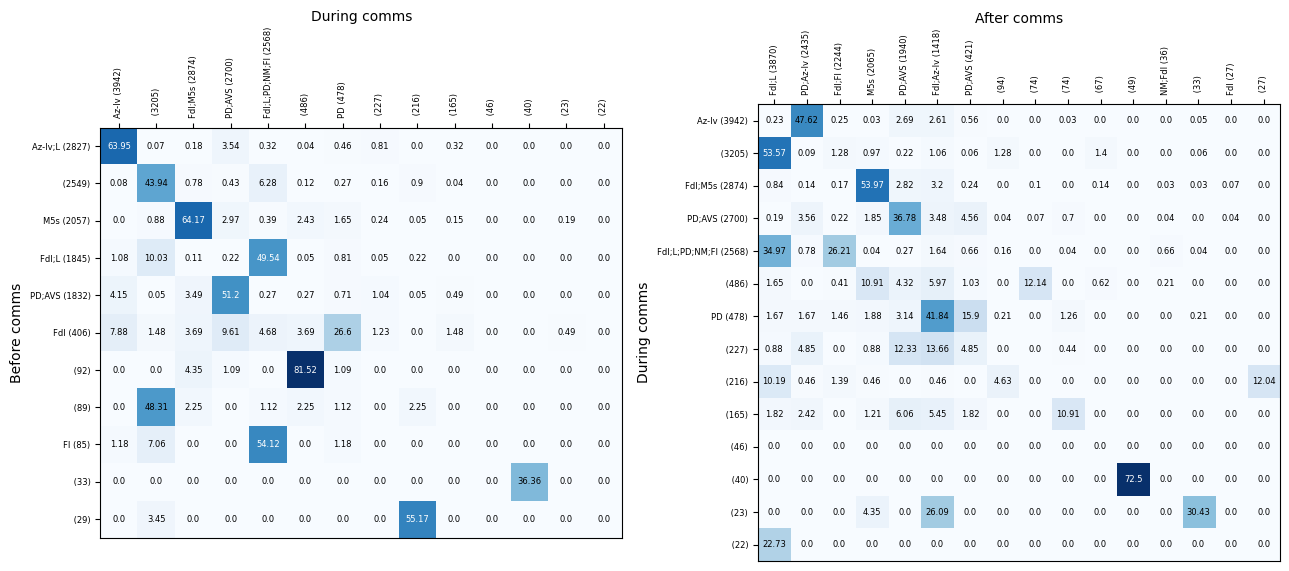

In [79]:
# plot a heatmap of the migration matrix
fig, ax = plt.subplots(1, 2, figsize=(13, 13))

text_colors = {True: 'white', False: 'black'}

im = ax[0].imshow(before_during_migration, cmap='Blues')
im = ax[1].imshow(during_after_migration, cmap='Blues')

# y-labels
ax[0].xaxis.set_label_position('top')
ax[0].set_ylabel('Before comms')
ax[0].set_xlabel('During comms')

ax[1].xaxis.set_label_position('top')
ax[1].set_ylabel('During comms')
ax[1].set_xlabel('After comms')

# Loop over data dimensions and create text annotations.
for i in range(0, len(sorted_before_comms_data)):
    for j in range(0, len(sorted_during_comms_data)):
        val = round(before_during_migration[i, j] * 100, 2) 
        text = ax[0].text(j, i, val, ha="center", va="center", size=6, color=text_colors[val > 49])

for i in range(0, len(sorted_during_comms_data)):
    for j in range(0, len(sorted_after_comms_data)):
        val1 = round(during_after_migration[i, j] * 100, 2)
        text = ax[1].text(j, i, val1, ha="center", va="center", size=6, color=text_colors[val1 > 49])

# We want to show all ticks...
ax[0].xaxis.tick_top()
ax[0].set_xticks(np.arange(len(sorted_during_comms_data)));
ax[0].set_yticks(np.arange(len(sorted_before_comms_data)));
ax[0].set_xticklabels(during_labels_size, rotation=90, size=6)
ax[0].set_yticklabels(before_labels_size, size=6)

ax[1].xaxis.tick_top()
ax[1].set_yticks(np.arange(len(sorted_during_comms_data)));
ax[1].set_xticks(np.arange(len(sorted_after_comms_data)));
ax[1].set_xticklabels(after_labels_size, rotation=90, size=6)
ax[1].set_yticklabels(during_labels_size, size=6)

fig.tight_layout()

#### Representatives migration

##### migration data

In [80]:
representatives_df = pd.read_csv("../../../data/raw_data/twitter_representatives_handles_final.csv")
representatives_ids = representatives_df["ids"].values

In [81]:
# def find_community(id, comms):
#     for index, comm in enumerate(comms):
#         if id in comm:
#             return index
#     return None

In [82]:
def find_community(id, comms_data):
    for idx in range(0, len(comms_data)):
        comm = comms_data[idx][1]
        if id in comm:
            return idx
    return None

In [87]:
representatives_communities = pd.DataFrame(columns=['id', 'period', 'community_id', 'community_label'])

bd_changes = 0
da_changes = 0

for repr in representatives_ids:
    b_comm = find_community(repr, sorted_before_comms_data)
    b_label = get_label(sorted_before_comms_data[b_comm][2]) if b_comm is not None else None
    representatives_communities.loc[len(representatives_communities)] = (repr, 'before', b_comm, b_label)

    d_comm = find_community(repr, sorted_during_comms_data)
    d_label = get_label(sorted_during_comms_data[d_comm][2]) if d_comm is not None else None
    representatives_communities.loc[len(representatives_communities)] = (repr, 'during', d_comm, d_label)

    a_comm = find_community(repr, sorted_after_comms_data)
    a_label = get_label(sorted_after_comms_data[a_comm][2]) if a_comm is not None else None
    representatives_communities.loc[len(representatives_communities)] = (repr, 'after', a_comm, a_label)

    if b_label != d_label:
        bd_changes += 1

    if d_label != a_label:
        da_changes += 1

In [88]:
bd_changes, da_changes

(128, 132)

In [90]:
representatives_communities.dropna(inplace=True)

In [91]:
output_path = f"../../../results/SNAM/communities/comms_composition_csv/representatives"
representatives_communities.to_csv(os.path.join(output_path, 'representatives_communities.csv'), index=False)

##### Migration matrix

In [92]:
before_during_repr_migration = np.zeros([len(sorted_before_comms_data), len(sorted_during_comms_data)])
during_after_repr_migration = np.zeros([len(sorted_during_comms_data), len(sorted_after_comms_data)])

In [93]:
def find_repr_overlap(comm1, comm2, representatives_ids, normalized=False):
    _comm1 = set(comm1).intersection(set(representatives_ids))
    _comm2 = set(comm2).intersection(set(representatives_ids))

    if len(set(_comm1)) == 0:
        return 0 

    if normalized:
        return len(set(_comm1).intersection(set(_comm2))) / len(set(_comm1)) #len(set(comm1).union(set(comm2)))

    return len(set(_comm1).intersection(set(_comm2)))

In [94]:
for i in range(0, len(sorted_before_comms_data)):
    for j in range(0, len(sorted_during_comms_data)):
        before_during_repr_migration[i][j] = find_repr_overlap(sorted_before_comms_data[i][1], sorted_during_comms_data[j][1], representatives_ids, normalized=True)

In [95]:
for i in range(0, len(sorted_during_comms_data)):
    for j in range(0, len(sorted_after_comms_data)):
        during_after_repr_migration[i][j] = find_repr_overlap(sorted_during_comms_data[i][1], sorted_after_comms_data[j][1], representatives_ids, normalized=True)

In [96]:
def expand_label_with_repr_size(label, comm, representatives_ids):
    _comm = set(comm).intersection(set(representatives_ids))
    size = ' (' + str(len(_comm)) + ')'
    return label+size

In [98]:
before_labels_repr_size = [expand_label_with_repr_size(before_labels[i], sorted_before_comms_data[i][1], representatives_ids) for i in range(0, len(sorted_before_comms_data))]
during_labels_repr_size = [expand_label_with_repr_size(during_labels[i], sorted_during_comms_data[i][1], representatives_ids) for i in range(0, len(sorted_during_comms_data))]
after_labels_repr_size = [expand_label_with_repr_size(after_labels[i], sorted_after_comms_data[i][1], representatives_ids) for i in range(0, len(sorted_after_comms_data))]

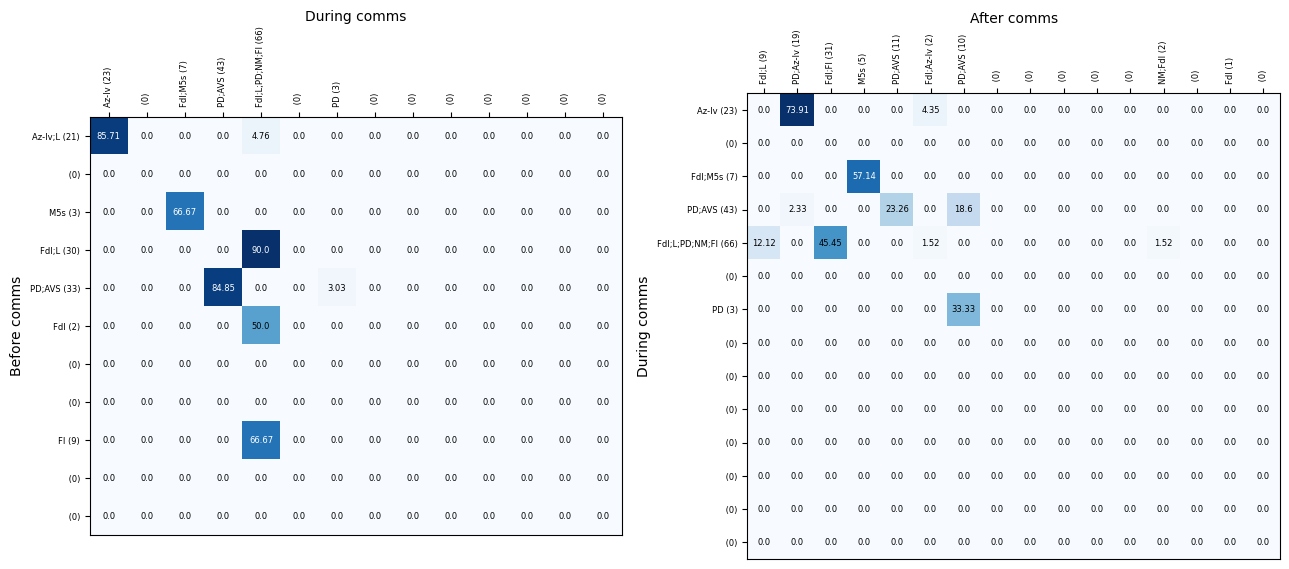

In [99]:
# plot a heatmap of the migration matrix
fig, ax = plt.subplots(1, 2, figsize=(13, 13))

text_colors = {True: 'white', False: 'black'}

im = ax[0].imshow(before_during_repr_migration, cmap='Blues')
im = ax[1].imshow(during_after_repr_migration, cmap='Blues')

# y-labels
ax[0].xaxis.set_label_position('top')
ax[0].set_ylabel('Before comms')
ax[0].set_xlabel('During comms')

ax[1].xaxis.set_label_position('top')
ax[1].set_ylabel('During comms')
ax[1].set_xlabel('After comms')

# Loop over data dimensions and create text annotations.
for i in range(len(sorted_before_comms_data)):
    for j in range(len(sorted_during_comms_data)):
        val = round(before_during_repr_migration[i, j] * 100, 2) 
        text = ax[0].text(j, i, val, ha="center", va="center", size=6, color=text_colors[val > 50])

for i in range(len(sorted_during_comms_data)):
    for j in range(len(sorted_after_comms_data)):
        val1 = round(during_after_repr_migration[i, j] * 100, 2)
        text = ax[1].text(j, i, val1, ha="center", va="center", size=6, color=text_colors[val1 > 50])

# We want to show all ticks...
ax[0].xaxis.tick_top()
ax[0].set_xticks(np.arange(len(sorted_during_comms_data)));
ax[0].set_yticks(np.arange(len(sorted_before_comms_data)));
ax[0].set_xticklabels(during_labels_repr_size, rotation=90, size=6)
ax[0].set_yticklabels(before_labels_repr_size, size=6)

ax[1].xaxis.tick_top()
ax[1].set_yticks(np.arange(len(sorted_during_comms_data)));
ax[1].set_xticks(np.arange(len(sorted_after_comms_data)));
ax[1].set_xticklabels(after_labels_repr_size, rotation=90, size=6)
ax[1].set_yticklabels(during_labels_repr_size, size=6)

fig.tight_layout()
